In [1]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_mnist, load_svhn
from models import DomainAdaptationNetwork, get_simple_classifier, ProjectorNetwork

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_tsne

In [2]:
torch.manual_seed(1)
import numpy as np
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(self.conv_feat_size[0], out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=nb_channels, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_share, z_spe):
        z = torch.cat([z_share, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(nb_channels, out_channels=32, kernel_size=5, padding=2),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Linear(in_features=self.dense_feature_size, out_features=2048)
        self.task_feat = nn.Linear(in_features=2048, out_features=latent_space_dim)
        self.source_feat = nn.Linear(in_features=2048, out_features=latent_space_dim)
        self.target_feat = nn.Linear(in_features=2048, out_features=latent_space_dim)

    def forward(self, input_data, mode='all'):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = F.relu(self.dense_feat(feat))
        if mode == 'task':
            z_task = F.relu(self.task_feat(feat))
            return z_task
        
        elif mode == 'source':
            z_source = F.relu(self.source_feat(feat))
            return z_source
        
        elif mode == 'target':
            z_target = F.relu(self.target_feat(feat))
            return z_target
        
        else:
            z_task = F.relu(self.task_feat(feat))
            z_source = F.relu(self.source_feat(feat))
            z_target = F.relu(self.target_feat(feat))
            return z_task, z_source, z_target        

In [4]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from utils import show_decoded_images
from models import GradReverse

criterion_reconstruction = nn.BCELoss()
criterion_classifier = nn.NLLLoss(reduction='mean')
criterion_weighted_classifier = nn.NLLLoss(reduction='none')
criterion_disentangle = nn.MSELoss()
criterion_distance = nn.MSELoss()
criterion_triplet = nn.TripletMarginLoss(margin=1)

criterion_reconstruction = nn.BCELoss()
disentangle_criterion = nn.MSELoss()
criterion_classifier = nn.NLLLoss(reduction='mean')
criterion_triplet = nn.TripletMarginLoss(margin=1)

def train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader, betas,
                            alpha=1, gamma=1, delta=0.1, epochs=30, show_images=False):

    t = tqdm(range(epochs))
    for epoch in t:
        total_loss = 0
        corrects_source, corrects_target = 0, 0
        total_source, total_target = 0, 0

        # random images used for disentanglement
        #xs_rand = next(iter(source_train_loader))[0].cuda()
        #xt_rand = next(iter(target_train_loader))[0].cuda()

        for (x_s, y_s), (x_t, y_t) in zip(source_train_loader, target_train_loader):
            loss = 0
            x_s, y_s, x_t, y_t = x_s.cuda(), y_s.cuda(), x_t.cuda(), y_t.cuda()
            min_len = min(len(x_s), len(x_t))
            x_s, y_s, x_t, y_t = x_s[:min_len], y_s[:min_len], x_t[:min_len], y_t[:min_len]
            # target batch
            xt_hat, yt_hat, (z_task, z_target), (pred_task, pred_spe) = model(x_t, mode='all_target')
            #Random projection to reduce the dimension
            random_task = random_projector(GradReverse.grad_reverse(z_task))
            random_spe = random_projector(GradReverse.grad_reverse(z_target))
            
            # synthetic sample with task information from x_t and style info from xs_rand
            xts = model.decode(z_task, x_s[:len(x_t)], mode='source')
            z_s = model.encoder(xts.detach(), mode='task')
            z_target_prime = model.encoder(torch.flip(x_t, [0])[:len(x_t)], mode='target')
            xt_prime = model.decoder_target(z_task, z_target_prime)
            yt_tilde, z_target_tilde = model.forward(xt_prime, mode='target')

            w, predicted = yt_hat.max(1)
            corrects_target += predicted.eq(y_t).sum().item()
            total_target += y_t.size(0)

            loss += alpha * criterion_reconstruction(xt_hat, x_t)
            loss += betas[epoch] * criterion_distance(z_task, z_s)
            loss += gamma * (criterion_disentangle(pred_task, random_task) + criterion_disentangle(pred_spe, random_spe))
            loss += 0.1 * torch.mean((torch.exp(w.detach()) * criterion_weighted_classifier(yt_tilde, predicted.detach())))
            loss += delta[epoch] * criterion_triplet(z_target_tilde, z_target_prime, z_target)

            # source batch
            xs_hat, ys_hat, (z_task, z_source), (pred_task, pred_spe) = model(x_s, mode='all_source')
            #Random projection to reduce the dimension
            random_task = random_projector(GradReverse.grad_reverse(z_task))
            random_spe = random_projector(GradReverse.grad_reverse(z_source))
            
            # synthetic sample with task information from x_s and style info from xt_rand
            xst = model.decode(z_task, x_t[:len(x_s)], mode='target')
            z_t = model.encoder(xst.detach(), mode='task')
            z_source_prime = model.encoder(torch.flip(x_s, [0])[:len(x_s)], mode='source')
            xs_prime = model.decoder_source(z_task, z_source_prime)
            ys_tilde, z_source_tilde = model(xs_prime, mode='source')

            _, predicted = ys_hat.max(1)
            corrects_source += predicted.eq(y_s).sum().item()
            total_source += y_s.size(0)

            loss += criterion_classifier(ys_hat, y_s)
            loss += alpha * criterion_reconstruction(xs_hat, x_s)
            loss += betas[epoch] * criterion_distance(z_task, z_t)
            loss += gamma * (criterion_disentangle(pred_task, random_task) + criterion_disentangle(pred_spe, random_spe))
            loss += 0.1 * criterion_classifier(ys_tilde, y_s.cuda())
            loss += delta[epoch] * criterion_triplet(z_source_tilde, z_source_prime, z_source)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += float(loss.data)
            t.set_description(f'epoch:{epoch} current target accuracy:{round(corrects_target / total_source * 100, 2)}%')
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, epochs, total_loss / len(source_train_loader)))
        print(f'accuracy source: {round(corrects_source / total_source * 100, 2)}%')
        print(f'accuracy target: {round(corrects_target / total_target * 100, 2)}%')
        if show_images:
            show_decoded_images(x_s[:16], xs_hat[:16], x_t[:len(x_s)][:16], xst[:16])
            show_decoded_images(x_t[:16], xt_hat[:16], x_s[:len(x_t)][:16], xts[:16])

In [8]:
target_train_loader, target_test_loader = load_mnist(img_size=32, batch_size=128, shuffle=True, num_workers=4, augment=False)
source_train_loader, source_test_loader = load_svhn(img_size=(32, 32), batch_size=128, split=1, shuffle=True, num_workers=4)

learning_rate = 5e-4
#epochs=10
epochs=30

encoder = Encoder(latent_space_dim=75, img_size=(3,32,32), nb_channels=3)
conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=3)
decoder_target = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=1)
classifier = get_simple_classifier(latent_space_dim=75)
model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()
random_projector = torch.cos
betas = np.linspace(0, 10, epochs)
delta = np.linspace(0, 10, epochs)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.001)

train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader, betas=betas,
                                            epochs=epochs, alpha=1, delta=delta, gamma=0.5, show_images=False)

Using downloaded and verified file: ../data/train_32x32.mat


epoch:0 current target accuracy:13.42%:   3%|▎         | 1/30 [00:38<18:22, 38.01s/it]

epoch [1/30], loss:4.3101
accuracy source: 37.12%
accuracy target: 13.42%


epoch:1 current target accuracy:44.58%:   7%|▋         | 2/30 [01:16<17:45, 38.05s/it]

epoch [2/30], loss:3.3870
accuracy source: 74.31%
accuracy target: 44.58%


epoch:2 current target accuracy:77.04%:  10%|█         | 3/30 [01:54<17:07, 38.06s/it]

epoch [3/30], loss:3.1773
accuracy source: 83.4%
accuracy target: 77.04%


epoch:3 current target accuracy:80.74%:  13%|█▎        | 4/30 [02:32<16:30, 38.08s/it]

epoch [4/30], loss:2.9787
accuracy source: 84.37%
accuracy target: 80.74%


epoch:4 current target accuracy:83.8%:  17%|█▋        | 5/30 [03:10<15:52, 38.11s/it] 

epoch [5/30], loss:2.6894
accuracy source: 87.14%
accuracy target: 83.8%


epoch:5 current target accuracy:88.77%:  20%|██        | 6/30 [03:48<15:15, 38.13s/it]

epoch [6/30], loss:2.6711
accuracy source: 87.96%
accuracy target: 88.77%


epoch:6 current target accuracy:89.5%:  23%|██▎       | 7/30 [04:26<14:36, 38.11s/it] 

epoch [7/30], loss:2.6764
accuracy source: 88.25%
accuracy target: 89.5%


epoch:7 current target accuracy:92.25%:  27%|██▋       | 8/30 [05:04<13:58, 38.13s/it]

epoch [8/30], loss:2.5306
accuracy source: 89.4%
accuracy target: 92.25%


epoch:8 current target accuracy:93.22%:  30%|███       | 9/30 [05:43<13:20, 38.12s/it]

epoch [9/30], loss:2.3218
accuracy source: 90.27%
accuracy target: 93.22%


epoch:9 current target accuracy:92.96%:  33%|███▎      | 10/30 [06:21<12:43, 38.16s/it]

epoch [10/30], loss:2.3042
accuracy source: 90.88%
accuracy target: 92.96%


epoch:10 current target accuracy:92.73%:  37%|███▋      | 11/30 [06:59<12:06, 38.23s/it]

epoch [11/30], loss:2.3009
accuracy source: 91.15%
accuracy target: 92.73%


epoch:11 current target accuracy:92.34%:  40%|████      | 12/30 [07:38<11:29, 38.33s/it]

epoch [12/30], loss:2.2832
accuracy source: 91.47%
accuracy target: 92.34%


epoch:12 current target accuracy:92.14%:  43%|████▎     | 13/30 [08:18<10:59, 38.80s/it]

epoch [13/30], loss:2.2622
accuracy source: 91.76%
accuracy target: 92.14%


epoch:13 current target accuracy:91.94%:  47%|████▋     | 14/30 [08:57<10:22, 38.91s/it]

epoch [14/30], loss:2.2494
accuracy source: 92.18%
accuracy target: 91.94%


epoch:14 current target accuracy:92.39%:  50%|█████     | 15/30 [09:35<09:42, 38.81s/it]

epoch [15/30], loss:2.2330
accuracy source: 92.51%
accuracy target: 92.39%


epoch:15 current target accuracy:92.32%:  53%|█████▎    | 16/30 [10:14<09:00, 38.62s/it]

epoch [16/30], loss:2.2277
accuracy source: 92.72%
accuracy target: 92.32%


epoch:16 current target accuracy:92.73%:  57%|█████▋    | 17/30 [10:52<08:20, 38.49s/it]

epoch [17/30], loss:2.2176
accuracy source: 92.84%
accuracy target: 92.73%


epoch:17 current target accuracy:93.06%:  60%|██████    | 18/30 [11:30<07:40, 38.38s/it]

epoch [18/30], loss:2.2133
accuracy source: 93.07%
accuracy target: 93.06%


epoch:18 current target accuracy:92.98%:  63%|██████▎   | 19/30 [12:08<07:01, 38.34s/it]

epoch [19/30], loss:2.2818
accuracy source: 93.22%
accuracy target: 92.98%


epoch:19 current target accuracy:93.42%:  67%|██████▋   | 20/30 [12:46<06:22, 38.27s/it]

epoch [20/30], loss:2.1843
accuracy source: 93.47%
accuracy target: 93.42%


epoch:20 current target accuracy:93.53%:  70%|███████   | 21/30 [13:25<05:44, 38.29s/it]

epoch [21/30], loss:2.1501
accuracy source: 93.61%
accuracy target: 93.53%


epoch:21 current target accuracy:93.5%:  73%|███████▎  | 22/30 [14:03<05:06, 38.26s/it] 

epoch [22/30], loss:2.1445
accuracy source: 93.88%
accuracy target: 93.5%


epoch:22 current target accuracy:93.31%:  77%|███████▋  | 23/30 [14:41<04:27, 38.27s/it]

epoch [23/30], loss:2.1332
accuracy source: 94.1%
accuracy target: 93.31%


epoch:23 current target accuracy:93.66%:  80%|████████  | 24/30 [15:19<03:49, 38.26s/it]

epoch [24/30], loss:2.1311
accuracy source: 94.09%
accuracy target: 93.66%


epoch:24 current target accuracy:93.44%:  83%|████████▎ | 25/30 [15:58<03:11, 38.28s/it]

epoch [25/30], loss:2.1190
accuracy source: 94.25%
accuracy target: 93.44%


epoch:25 current target accuracy:93.36%:  87%|████████▋ | 26/30 [16:36<02:32, 38.24s/it]

epoch [26/30], loss:2.0527
accuracy source: 94.43%
accuracy target: 93.36%


epoch:26 current target accuracy:93.04%:  90%|█████████ | 27/30 [17:14<01:54, 38.26s/it]

epoch [27/30], loss:2.0011
accuracy source: 94.56%
accuracy target: 93.04%


epoch:27 current target accuracy:92.61%:  93%|█████████▎| 28/30 [17:52<01:16, 38.24s/it]

epoch [28/30], loss:1.9881
accuracy source: 94.67%
accuracy target: 92.61%


epoch:28 current target accuracy:93.09%:  97%|█████████▋| 29/30 [18:30<00:38, 38.22s/it]

epoch [29/30], loss:1.9841
accuracy source: 94.84%
accuracy target: 93.09%


epoch:29 current target accuracy:93.32%: 100%|██████████| 30/30 [19:09<00:00, 38.31s/it]

epoch [30/30], loss:1.9496
accuracy source: 94.91%
accuracy target: 93.32%


In [ ]:
betas = np.ones(epochs) * 10
delta = np.ones(epochs) * 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)

train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader, betas=betas,
                                            epochs=epochs, alpha=1, delta=delta, gamma=0.5, show_images=False)

epoch:0 current target accuracy:93.48%:   3%|▎         | 1/30 [00:38<18:30, 38.30s/it]

epoch [1/30], loss:1.8781
accuracy source: 96.03%
accuracy target: 93.48%


epoch:1 current target accuracy:93.78%:   3%|▎         | 1/30 [00:52<18:30, 38.30s/it]

In [6]:
model.eval()
test_network(model, target_test_loader)

0.9225

In [ ]:
import matplotlib.pyplot as plt
def plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader):
    X, _ = next(iter(target_train_loader))
    y, _, (z_share, z_spe),  _ = model(X.cuda(), mode='all_target')
    X2, _ = next(iter(source_train_loader))
    _, _, (z_share, _),  _ = model(X2.cuda(), mode='all_target')
    #blank
    plt.subplot(1,6,1)
    plt.imshow(torch.ones((32,32,3)))
    plt.axis('off')
    plt.tight_layout()
    #styles
    for i in range(5):
        plt.subplot(1,6,i+2)
        plt.imshow(X[i].cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.tight_layout()

    for j in range(10, 20):
        plt.figure()
        plt.subplot(1,6,1)
        plt.imshow(X2[j].cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.tight_layout()

        z_x = torch.zeros_like(z_share)
        z_x[:] = z_share[j]
        y2  = model.decoder_target(z_x, z_spe)
        for i in range(5):
            plt.subplot(1,6,i+2)
            plt.imshow(y2[i].cpu().detach().permute(1, 2, 0))
            plt.axis('off')
            plt.tight_layout()

In [ ]:
plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader)
plot_tsne(model, source_train_loader, target_train_loader, 128, 75)

epoch:0 current target accuracy:92.5%:   0%|          | 0/30 [00:38<?, ?it/s] 

epoch [1/30], loss:0.8821
accuracy source: 99.03%
accuracy target: 92.5%


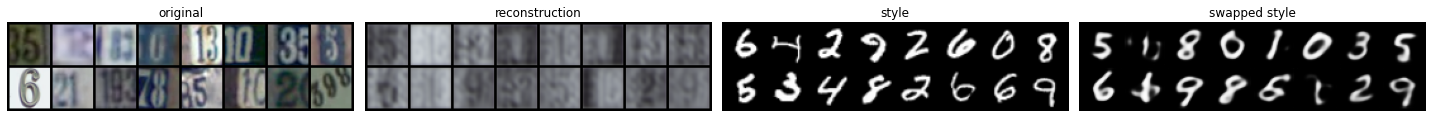

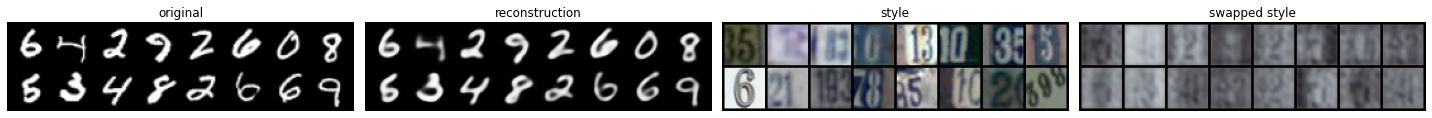

epoch:1 current target accuracy:92.6%:   3%|▎         | 1/30 [01:16<18:44, 38.76s/it] 

epoch [2/30], loss:0.8624
accuracy source: 99.55%
accuracy target: 92.6%


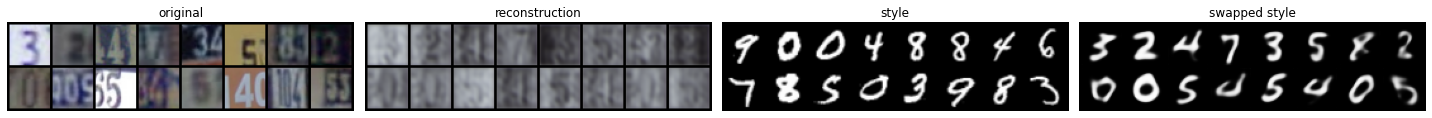

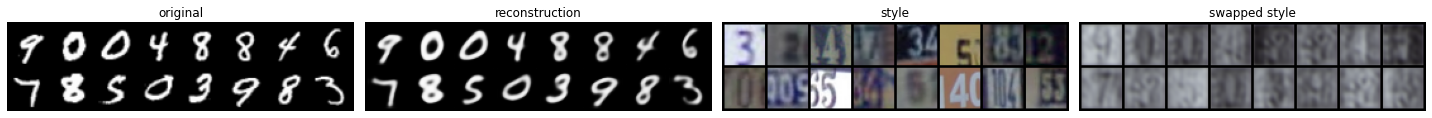

epoch:2 current target accuracy:92.72%:   7%|▋         | 2/30 [01:55<18:02, 38.67s/it]

epoch [3/30], loss:0.8573
accuracy source: 99.62%
accuracy target: 92.72%


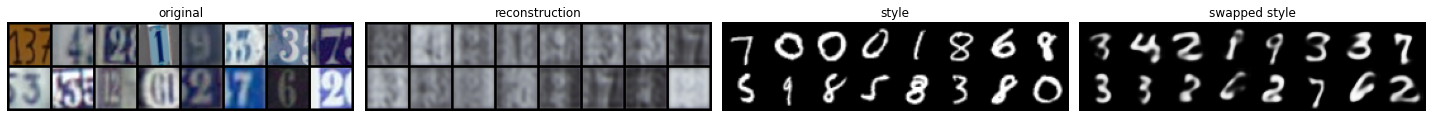

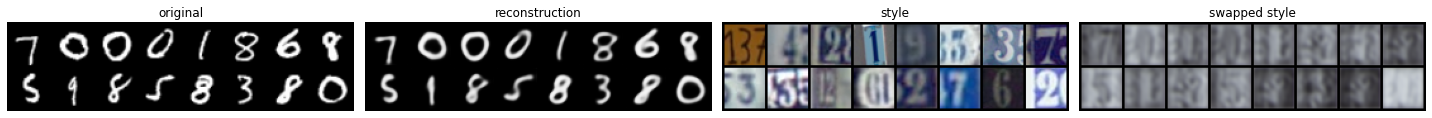

epoch:3 current target accuracy:92.73%:  10%|█         | 3/30 [02:32<22:54, 50.90s/it]


KeyboardInterrupt: 

In [7]:
model.train()
betas = np.ones(30) * 5

delta = np.ones(30) * 5
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)

train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader, betas=betas,
                                            epochs=epochs, alpha=1, delta=delta, gamma=0.1, show_images=True)